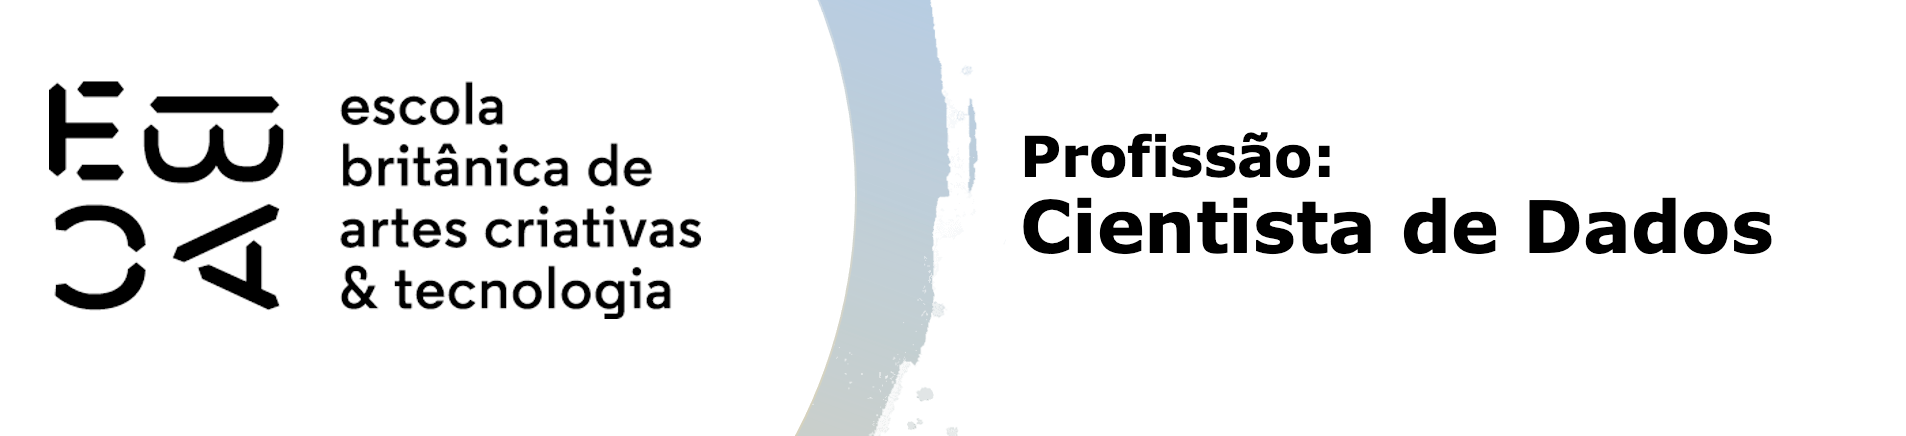

# Tarefa II

Ainda sobre a base da NFP vista na tarefa passada:

|Campo|Descrição|
|:-|:-|
|CNPJ emit.| CNPJ do emitente da nota|
|Emitente| Nome fantasia do emitente da nota|
|No.| Número da nota fiscal|
|Data Emissão| Data de emissão da nota fiscal|
|Valor NF| Valor da nota fiscal|
|Data Registro| Data de registro no sistema da NFP|
|Créditos| Valor dos créditos (doação)|
|Situação do Crédito| Se o crédito já foi pago, está sendo processado etc.|
|Ano| Ano da emissão da nota|
|Semestre| Semestre da emissão da nota|
|Retorno| Valor do crédito dividido pelo valor da nota|
|flag_credito| Indicadora se a nota possui crédito positivo|
|categoria| Categorização da nota |

**OBJETIVO:** Algumas notas não dão retorno, o que pode ocorrer por diversos motivos, um deles seria a ocorrência de produtos não incentivados como cigarros e bebidas alcólicas. O nosso objetivo é tentar prever que tipo de nota tem maior ou menor propensão a fornecer créditos.

**Observação**: Esta é uma base real, havendo características de acordo. Pode haver uma variabilidade difícil de explicar, em parte por causa de uma freqüência de notas inconstante no tempo (por diversos motivos), em parte por haverem informações importantes, protegidas pela LGPD, não constantes na base, que pode interferir no crédito gerado, o que vai ocasionar uma variabilidade difícil de se explicar. *Welcome to the jungle*, A vida real é assim :)

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_pickle('base_nfp.pkl')
df.head(1)

,CNPJ emit.,Emitente,No.,Data Emissão,Valor NF,Data Registro,Créditos,Situação do Crédito,Ano,Semestre,Retorno,flag_credito,categoria
0,03.476.811/0741-98,DIA BRASIL SOCIEDADE LIMITADA,537,2017-06-30,24.68,2017-06-30,0.0,Liberado,2017,1,0.0,0,Mercado


## Criando variáveis

**Variáveis temporais**: É possível que haja alguma regra de liberação de créditos de acordo com o dia do mês, o dia da semana, fim de semana (sim ou não), ou até alterações temporais da regra. Vamos criar as seguintes variáveis para testar estas hipóteses:

- Dia da semana
- Dummy para fim de semana
- Dia do mês
- Mês (já na base)
- Trimestre
- Ano (já na base)

**Valor da nota**: Vamos criar também algumas variáveis para resumir o valor da nota, e posteriormente criar uma intuição sobre categorizações de variáveis contínuas.

- Crie categorizações da variável ```Valor NF```, por quantís, em 5, 10, 20 e 50 categorias.

In [19]:
# dia da semana
df['dia_semana'] = df['Data Emissão'].dt.weekday

# dummy para fim de semana (1 = fim de semana, 0 = dia útil)
df['fim_de_semana'] = df['Data Emissão'].dt.weekday.isin([5,6]).astype(int)

# dia do mês
df['dia_mes'] = df['Data Emissão'].dt.day

# trimestre
df['trimestre'] = df['Data Emissão'].dt.quarter

# mês
df['mes'] = df['Data Emissão'].dt.month

In [20]:
# 5 categorias (quintis)
df['ValorNF_5cat'] = pd.qcut(df['Valor NF'], q=5, labels=False)

# 10 categorias (decis)
df['ValorNF_10cat'] = pd.qcut(df['Valor NF'], q=10, labels=False)

# 20 categorias
df['ValorNF_20cat'] = pd.qcut(df['Valor NF'], q=20, labels=False)

# 50 categorias
df['ValorNF_50cat'] = pd.qcut(df['Valor NF'], q=50, labels=False)

## Calcule o IV de todas essas variáveis

Sugestão: Construa um metadados e tente utilizar uma função como a que foi utilizada durante a aula. Você vai conseguir fazer esse cálculo para as variáveis uma a uma, mas em casos reais em que vamos mais além na criação de variáveis, podemos ter centenas, ou até milhares de variáveis, esses cálculos *precisam* ser automáticos nesses casos.

In [22]:
def calcular_iv(df, feature, target):
    # cria uma tabela cruzando a variável e a variável alvo
    tabela = pd.crosstab(df[feature], df[target])
    # ajusta em caso de missing values
    tabela = tabela + 0.5
    tabela.columns = ['bom', 'ruim'] # ajuste conforme o nome da sua target (0/1)
    tabela['pct_bom'] = tabela['bom'] / tabela['bom'].sum()
    tabela['pct_ruim'] = tabela['ruim'] / tabela['ruim'].sum()
    tabela['woe'] = np.log(tabela['pct_bom'] / tabela['pct_ruim'])
    tabela['iv'] = (tabela['pct_bom'] - tabela['pct_ruim']) * tabela['woe']
    return tabela['iv'].sum()

In [25]:
variaveis = [
    'dia_semana', 'fim_de_semana', 'dia_mes', 'trimestre', 'mes',
    'ValorNF_5cat', 'ValorNF_10cat', 'ValorNF_20cat', 'ValorNF_50cat'
]

iv_resultados = {var: calcular_iv(df, var, 'flag_credito') for var in variaveis}

iv_df = pd.DataFrame.from_dict(iv_resultados, orient='index', columns=['IV'])

iv_df = iv_df.sort_values(by='IV', ascending=False)

print(iv_df)

                     IV
ValorNF_50cat  0.152217
ValorNF_20cat  0.124495
ValorNF_10cat  0.106638
ValorNF_5cat   0.056692
dia_mes        0.043706
mes            0.027830
trimestre      0.011507
dia_semana     0.006883
fim_de_semana  0.004346


## Conclua

- Quais variáveis parecem apresentar maior poder de discriminação segundo o IV?
- Quando categorizamos variáveis contínuas parece haver alguma relação entre o número de categorias e o IV?

Categorização do IV:

IV < 0,02: Pouca ou nenhuma capacidade de separação.   
0,02 ≤ IV < 0,1: Baixa capacidade de separação.   
0,1 ≤ IV < 0,3: Capacidade média.   
0,3 ≤ IV < 0,5: Forte capacidade.   
IV ≥ 0,5: Muito forte, mas pode indicar overfitting.

Com base nisso, podemos categorizar as variáveis com maior poder de discriminação da seguinte forma

- ValorNF_50cat: IV = 0.152217 (Capacidade média)   
- ValorNF_20cat: IV = 0.124495 (Capacidade média)   
- ValorNF_10cat: IV = 0.106638 (Capacidade média)   
- ValorNF_5cat: IV = 0.056692 (Baixa capacidade)

1. As variáveis que apresentam maior poder de discriminação conforme o IV são as derivadas da categorização do Valor NF, principalmente aquelas com mais categorias (50, 20 e 10). Elas possuem IV entre 0,1 e 0,3, indicando capacidade média de separar as classes.

2. Ao categorizar variáveis contínuas em mais grupos, o IV tende a aumentar, pois há maior detalhamento das diferenças entre as classes. Mas ainda assim é necessário equilibrar a quantidade de categorias, para não exagerar na segmentação e evitar overfitting.

## Descritiva simples no tempo

Para compor a análise que virá a seguir, faça uma análise descritiva básica no tempo - utilize trimestre como agregação (ou uma média móvel por trimestre, como preferir) e avalie graficamente:

- A quantidade de notas registradas na base por período
- A quantidade de notas por categoria e por período
- A proporção de notas com crédito por categoria por período

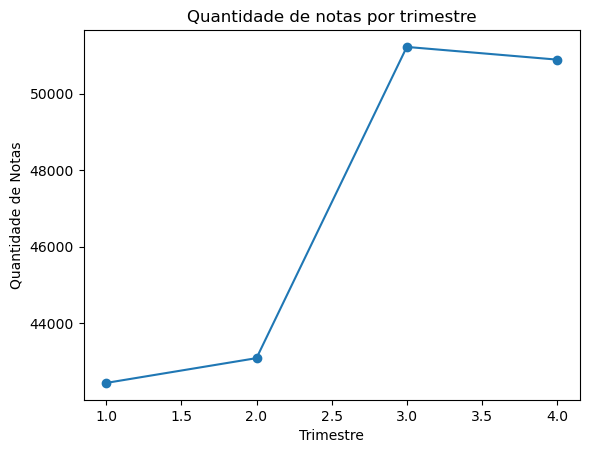

In [26]:
# quantidade de notas registradas por trimestre
notas_por_trimestre = df.groupby('trimestre').size()
notas_por_trimestre.plot(marker='o', title='Quantidade de notas por trimestre')
plt.xlabel('Trimestre')
plt.ylabel('Quantidade de Notas')
plt.show()

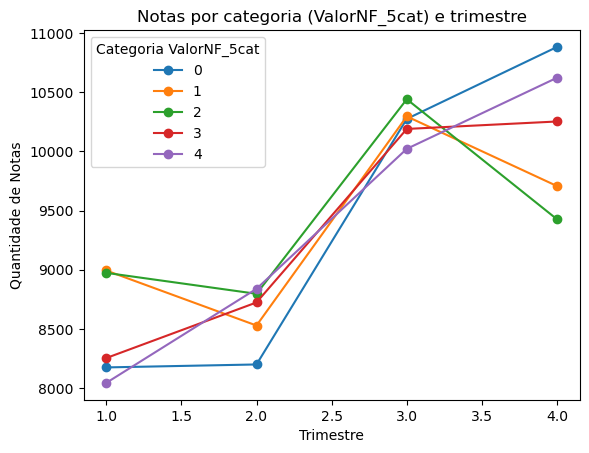

In [35]:
# quantidade de notas por categoria e por trimestre (NF_5cat)
notas_cat_trimestre = df.groupby(['trimestre', 'ValorNF_5cat']).size().unstack().fillna(0)
notas_cat_trimestre.plot(kind='line', marker='o', title='Notas por categoria (ValorNF_5cat) e trimestre')
plt.xlabel('Trimestre')
plt.ylabel('Quantidade de Notas')
plt.legend(title='Categoria ValorNF_5cat')
plt.show()

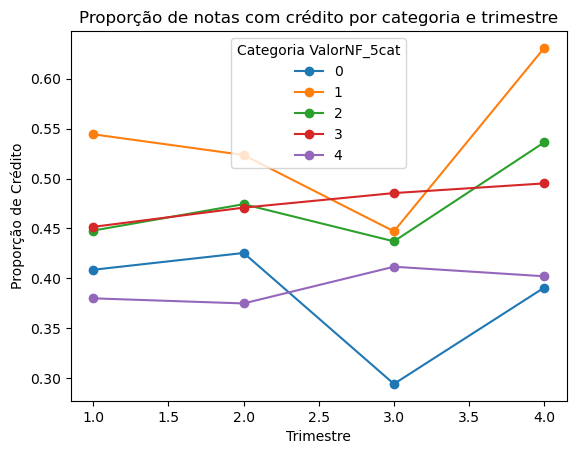

In [37]:
# proporção de notas com crédito por categoria e por trimestre
# calcula a proporção: soma de flag_credito / total, agrupado por trimestre e categoria
proporcao = (
    df.groupby(['trimestre', 'ValorNF_5cat'])['flag_credito']
    .mean()
    .unstack()
)
proporcao.plot(marker='o', title='Proporção de notas com crédito por categoria e trimestre')
plt.xlabel('Trimestre')
plt.ylabel('Proporção de Crédito')
plt.legend(title='Categoria ValorNF_5cat')
plt.show()

## Avalie o WOE e o IV no tempo

Avalie o WOE e o IV no tempo da variável ```categoria```.

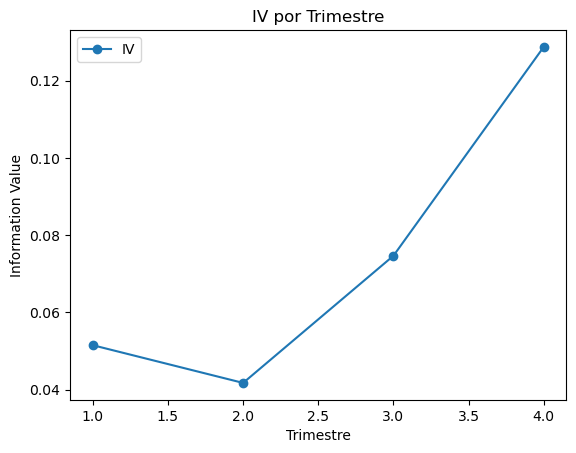

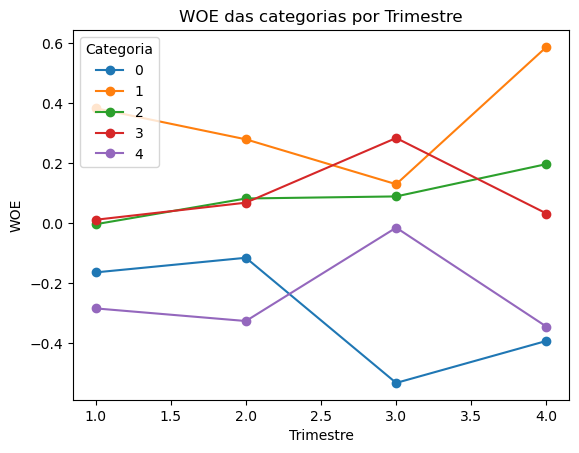

In [34]:
def calcular_woe_iv(df, feature, target):
    tabela = pd.crosstab(df[feature], df[target])
    tabela = tabela + 0.5
    tabela.columns = [str(col) for col in tabela.columns]
    good = '1'
    bad = '0'
    tabela['pct_1'] = tabela[good] / tabela[good].sum()
    tabela['pct_0'] = tabela[bad] / tabela[bad].sum()
    tabela['woe'] = np.log(tabela['pct_1'] / tabela['pct_0'])
    tabela['iv'] = (tabela['pct_1'] - tabela['pct_0']) * tabela['woe']
    return tabela['woe'], tabela['iv'].sum()

woe_trimestre = {}
iv_trimestre = []

for trimestre, grupo in df.groupby('trimestre'):
    woe, iv = calcular_woe_iv(grupo, 'ValorNF_5cat', 'flag_credito')
    woe_trimestre[trimestre] = woe
    iv_trimestre.append({'trimestre': trimestre, 'IV': iv})

iv_df = pd.DataFrame(iv_trimestre).set_index('trimestre')

iv_df.plot(marker='o', title='IV por Trimestre')
plt.xlabel('Trimestre')
plt.ylabel('Information Value')
plt.show()

woe_df = pd.DataFrame(woe_trimestre)
woe_df.T.plot(marker='o', title='WOE das categorias por Trimestre')
plt.xlabel('Trimestre')
plt.ylabel('WOE')
plt.legend(title='Categoria')
plt.show()

## Conclua

- Quais categorias parece ter maior proporção de notas com retornos maiores que zero?
- Essas diferenças são estáveis no tempo?

Dicas:<br>
- Considere que a quantidade de notas vem aumentando
- Considere que há períodos bem atípicos no histórico
- Considere que a partir de janeiro de 2020 o público é mais parecido com o público atual (2022), seja por pandemia, seja por crescimento do público, e considere os dados dessa data em diante na sua conclusão.

A categoria 1 (e em parte a 2 e 3) mostra melhor desempenho na proporção de notas com retorno maior que zero, principalmente a partir do 3º trimestre, como mostra o gráfico.

As diferenças entre as categorias não são totalmente estáveis ao longo do tempo, visto que, A partir do 3º trimestre (2020 em diante), observa-se um aumento do IV e uma separação mais marcada entre as categorias. Isso pode estar relacionado à ampliação do público ou a fatores externos como a pandemia, por exemplo.